In [1]:
options(warn=-1)
library(scater, quietly = TRUE)
library(dplyr)
library(SC3)
library(data.table)
library(gProfileR)
library(ggplot2)
library(GGally)
library(gplots)
library(M3Drop)
library(DESeq2)
library(limma)
library(Seurat)
library(gProfileR)
options(stringsAsFactors = FALSE)
options(warn=0)


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Attachi

In [2]:
library(IRdisplay)

In [3]:
tpm_data <- data.frame(
  fread('data/tpm_t.csv'), row.names = 1)
qc <- data.frame(
  fread('data/salmon_qc.csv'), row.names = 1)
metadata <- data.frame(
  fread('data/technical_metadata.csv'), 
  row.names = 1)
mt_genes <- read.csv(
  '../annotations/human_mt_genes.tsv',
  header = TRUE,  sep = '\t')
symbol_map <- read.table(
  "../annotations/human_annotation_map.tsv", 
  header = TRUE, sep = '\t')
membrane_db <- read.table(
  "../annotations/plasma_membrane_rvt.csv", header = T, sep = ",")

Read 1536 rows and 61559 (of 61559) columns from 0.380 GB file in 00:00:22


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”

In [4]:
source('../r_utilities/utilities.R')

tpm_data <- replace_ensembl_gene(tpm_data, symbol_map, axis = 2, drop_duplicates = T)
gene_names <- colnames(tpm_data)
membrane_genes <- membrane_db$Gene_ID

# Merge the qc and metadata files
annotation_df <- merge(metadata, qc, by = 0, all.x = TRUE, sort = TRUE)
rownames(annotation_df) <- annotation_df[,"sample_name"]

# Change the rownames of the tpm
sample_names <- annotation_df[
  match(rownames(tpm_data), annotation_df[,'Row.names']), "sample_name"]
rownames(tpm_data) <- sample_names

# Filter out QC samples not in the TPM table
annotation_df <- annotation_df[rownames(annotation_df) %in% rownames(tpm_data), ]

# Sort the rows of qc and tpm to ensure equality
annotation_df <- annotation_df[ order(row.names(annotation_df)), ]
tpm_data <- tpm_data[ order(row.names(tpm_data)), ]

sample_types <- unique(annotation_df$sample_type)

In [5]:
# Control Wells
control_labels <- c("Bulk control", "Empty", "RNA")
annotation_df$is_control <- annotation_df$sample_type %in% control_labels

control_annotation <- annotation_df[annotation_df$is_control, ]
cell_annotation <- annotation_df[!annotation_df$is_control, ]

control_tpm <- tpm_data[annotation_df$is_control, ]
cell_tpm <- tpm_data[!annotation_df$is_control, ]

# Remove samples from other experiments
alien_samples <- c("ARS004 Blood ILC cells", 
                   "ARS005 Blood CD4 T cells", 
                   "ARS005 Blood ILC cells")
alien_indices = cell_annotation$sample_type %in% alien_samples
cell_annotation <- cell_annotation[!alien_indices, ]
cell_tpm <- cell_tpm[!alien_indices, ]

In [9]:
# Create the scater object
pheno_data <- new("AnnotatedDataFrame", cell_annotation)
rownames(pheno_data) <- pheno_data$sample_name

sceset <- scater::newSCESet(
  tpmData = t(cell_tpm),
  phenoData = pheno_data
)

Warning message in scater::newSCESet(tpmData = t(cell_tpm), phenoData = pheno_data):
“'logExprsOffset' should be set manually for non-count data”

In [12]:
# Get the ERCC and MT values
ercc <- featureNames(sceset)[grepl("ERCC.", featureNames(sceset))]
mt_list <- mt_genes$Associated.Gene.Name

# Define minimum expression limit
is_exprs(sceset) <- exprs(sceset) > 1

sceset <- scater::calculateQCMetrics(
  sceset,
  feature_controls = list(ERCC = ercc, MT = mt_list)
)

[1] "MT-TF"   "MT-RNR1" "MT-TV"   "MT-RNR2" "MT-TL1"  "MT-ND1"  "MT-TI"  
 [8] "MT-TQ"   "MT-TM"   "MT-ND2"  "MT-TW"   "MT-TA"   "MT-TN"   "MT-TC"  
[15] "MT-TY"   "MT-CO1"  "MT-TS1"  "MT-TD"   "MT-CO2"  "MT-TK"   "MT-ATP8"
[22] "MT-ATP6" "MT-CO3"  "MT-TG"   "MT-ND3"  "MT-TR"   "MT-ND4L" "MT-ND4" 
[29] "MT-TH"   "MT-TS2"  "MT-TL2"  "MT-ND5"  "MT-ND6"  "MT-TE"   "MT-CYB" 
[36] "MT-TT"   "MT-TP"

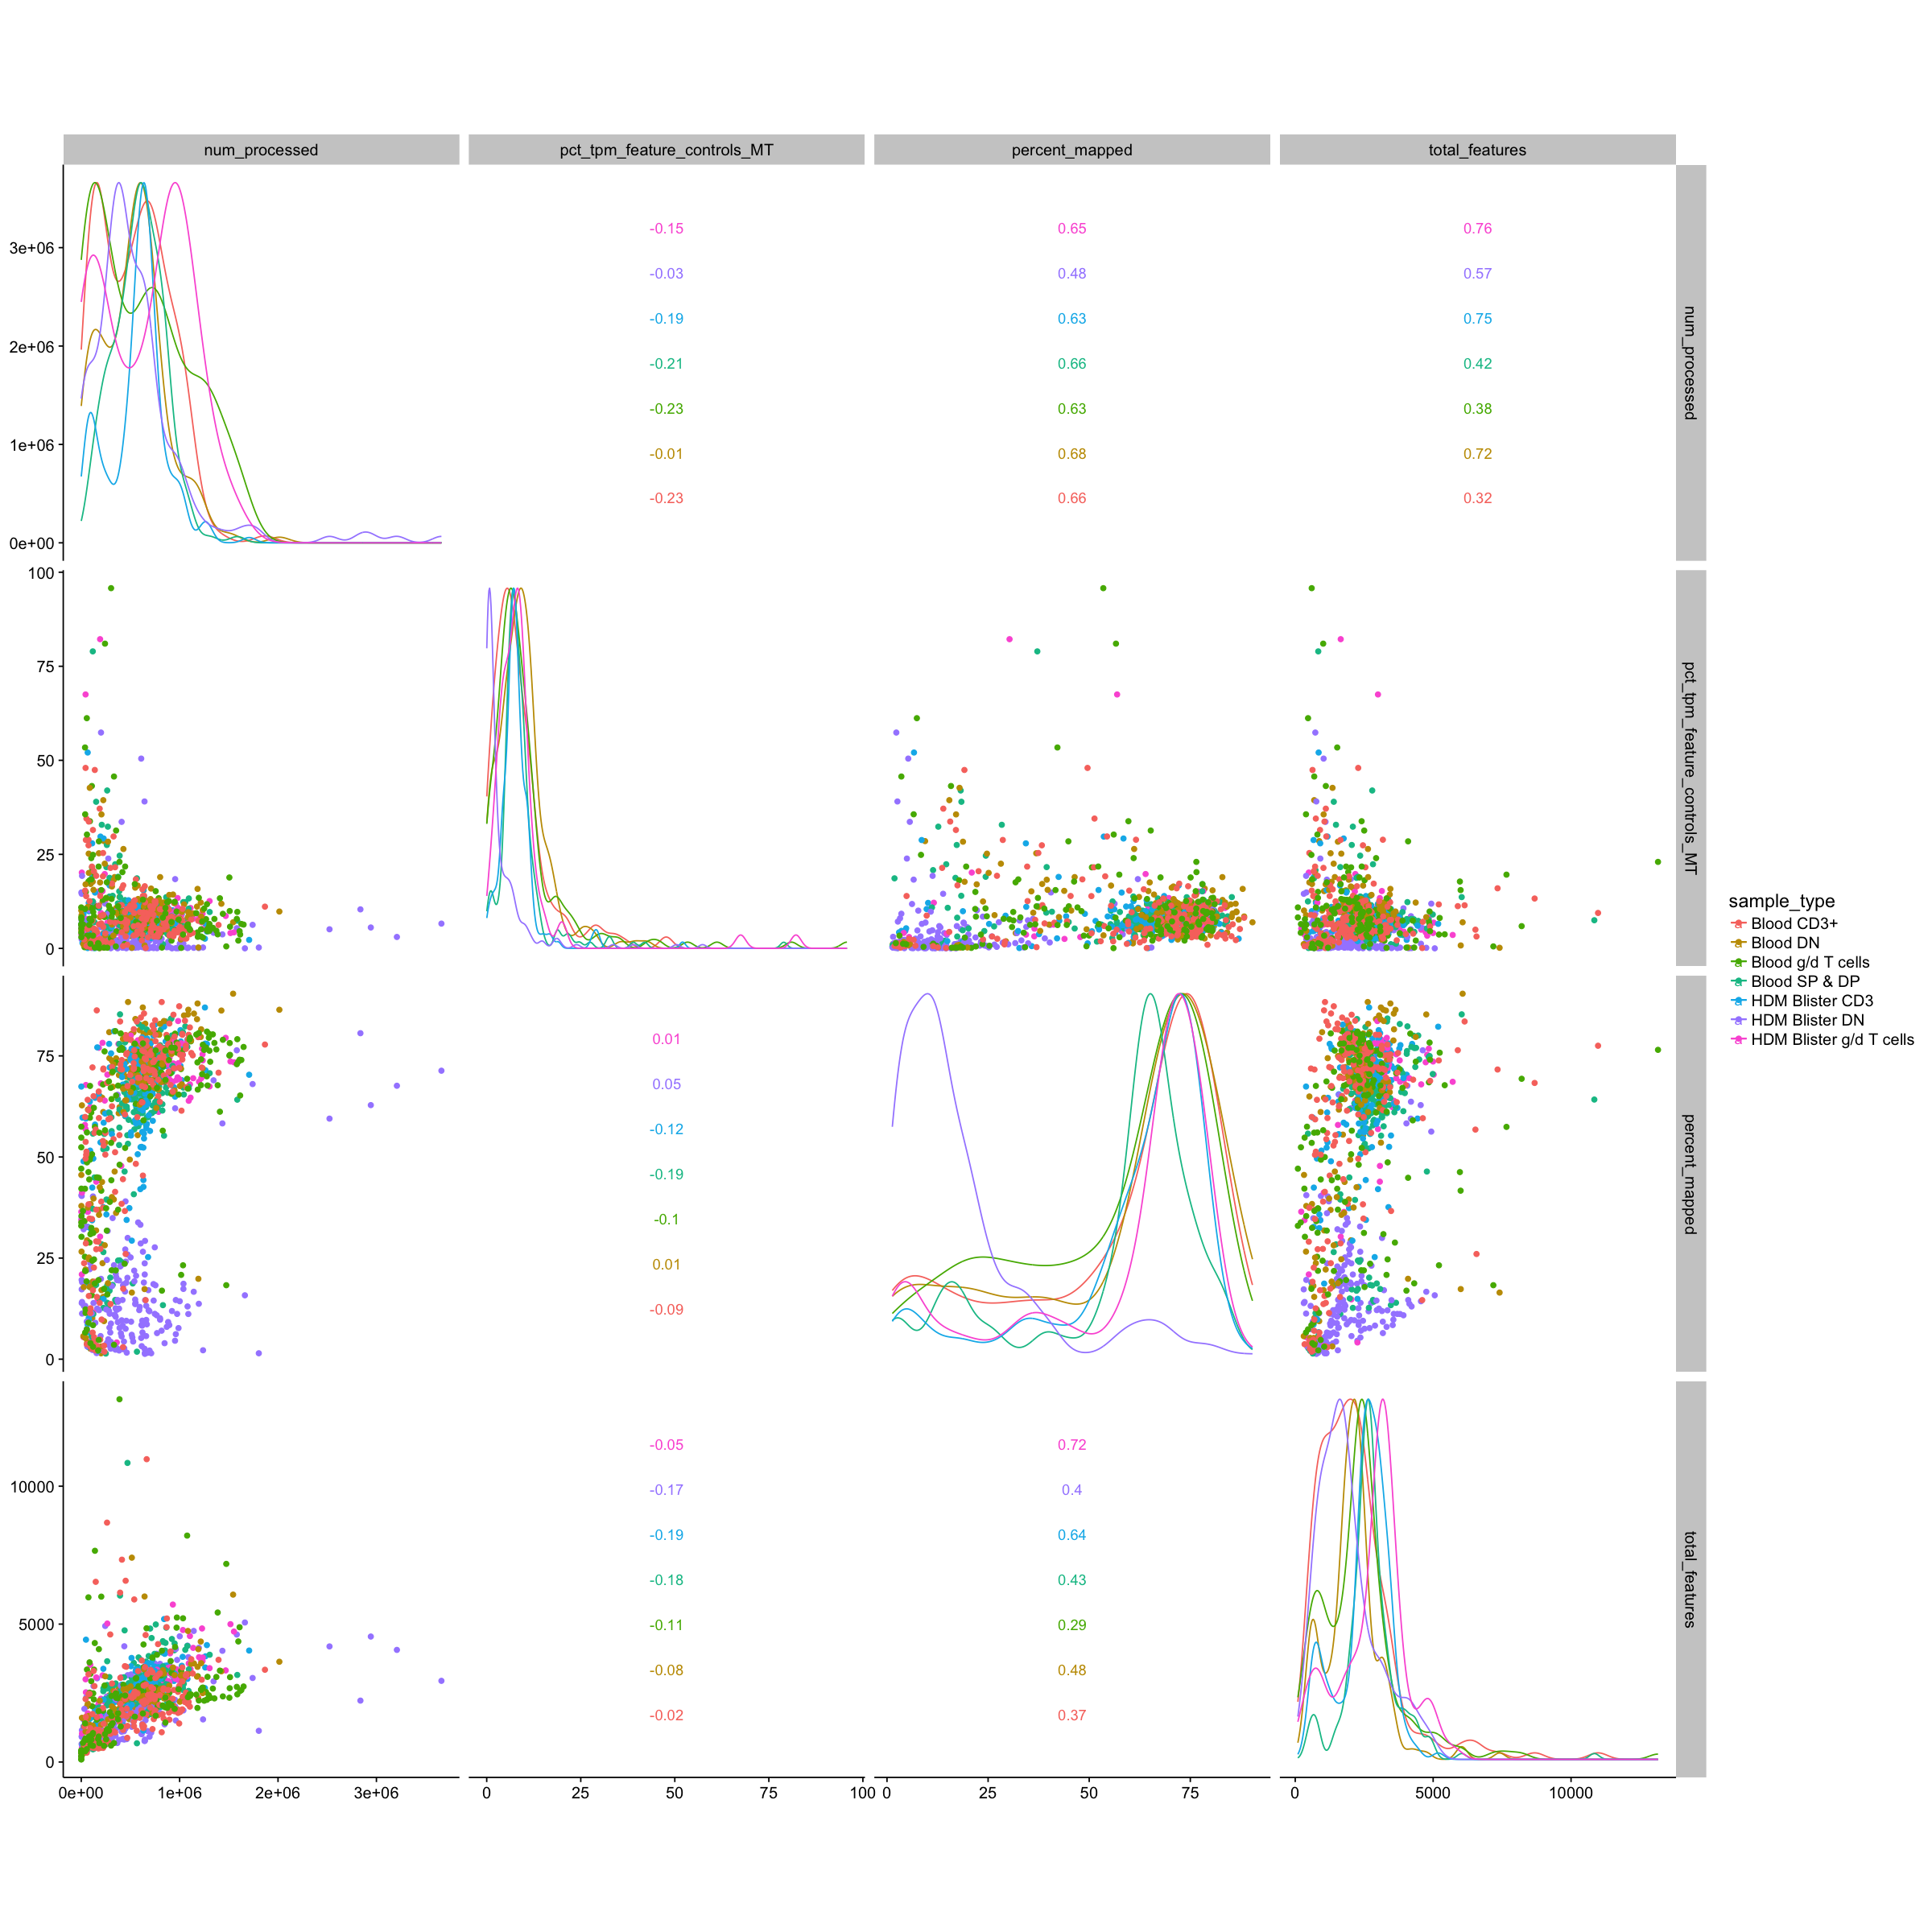

In [16]:
options(repr.plot.width = 20, repr.plot.height = 20)
ggscatmat(
  sceset@phenoData@data,
  columns = c("num_processed", "total_features", 
              "percent_mapped", "pct_tpm_feature_controls_MT"),
  color = "sample_type"
)

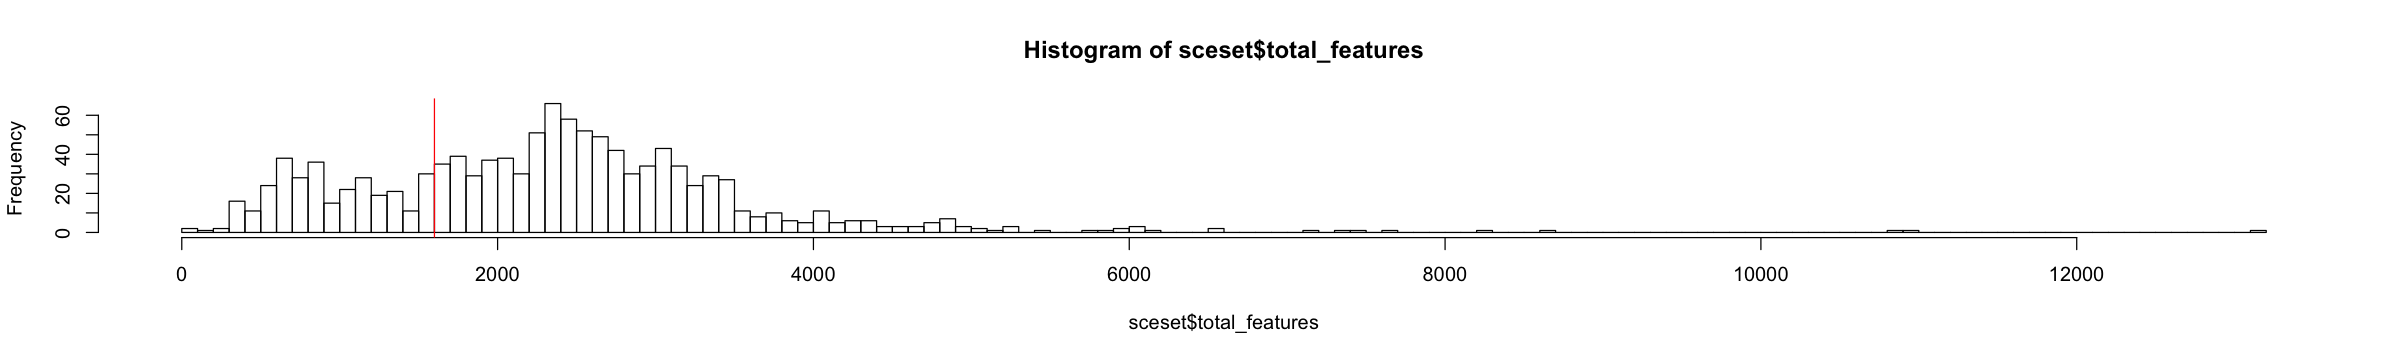

In [15]:
hist(sceset$total_features, breaks = 100)
abline(v = 1600, col = "red")

In [17]:
# Define filters
filter_total_features = sceset$total_features > 1600
filter_num_mapped = sceset$num_mapped > 150000
filter_pct_mt <- sceset$pct_tpm_feature_controls_MT < 20
filter_pct_mapped <- sceset$percent_mapped > 50

sceset$use <- (
  filter_total_features &
  filter_num_mapped &
  filter_pct_mt &
  filter_pct_mapped
)

sceset$quality_color <- ifelse(sceset$use, "accept", "reject")

# Default filter

sceset$use_default <- (
  !sceset$filter_on_total_features &
  !sceset$filter_on_total_counts &
  !sceset$filter_on_pct_tpm_feature_controls_ERCC &
  !sceset$filter_on_pct_tpm_feature_controls_MT
)

In [ ]:
# Automatic PCA filter on quality features (Doesn't really work for TPM)
sceset <- scater::plotPCA(
  sceset, 
  size_by = "total_features",
  shape_by = "use",
  pca_data_input = "pdata",
  detect_outliers = TRUE,
  return_SCESet  = TRUE,
  exprs_values = "tpm",
  selected_variables = c("pct_exprs_top_100_features", 
                         "total_features", 
                         "pct_exprs_feature_controls",
                         "n_detected_feature_controls",
                         "log10_exprs_endogenous_features",
                         "log10_counts_feature_controls")
)

# Remove detected outliers
sceset$use <- sceset$use & !sceset$outlier


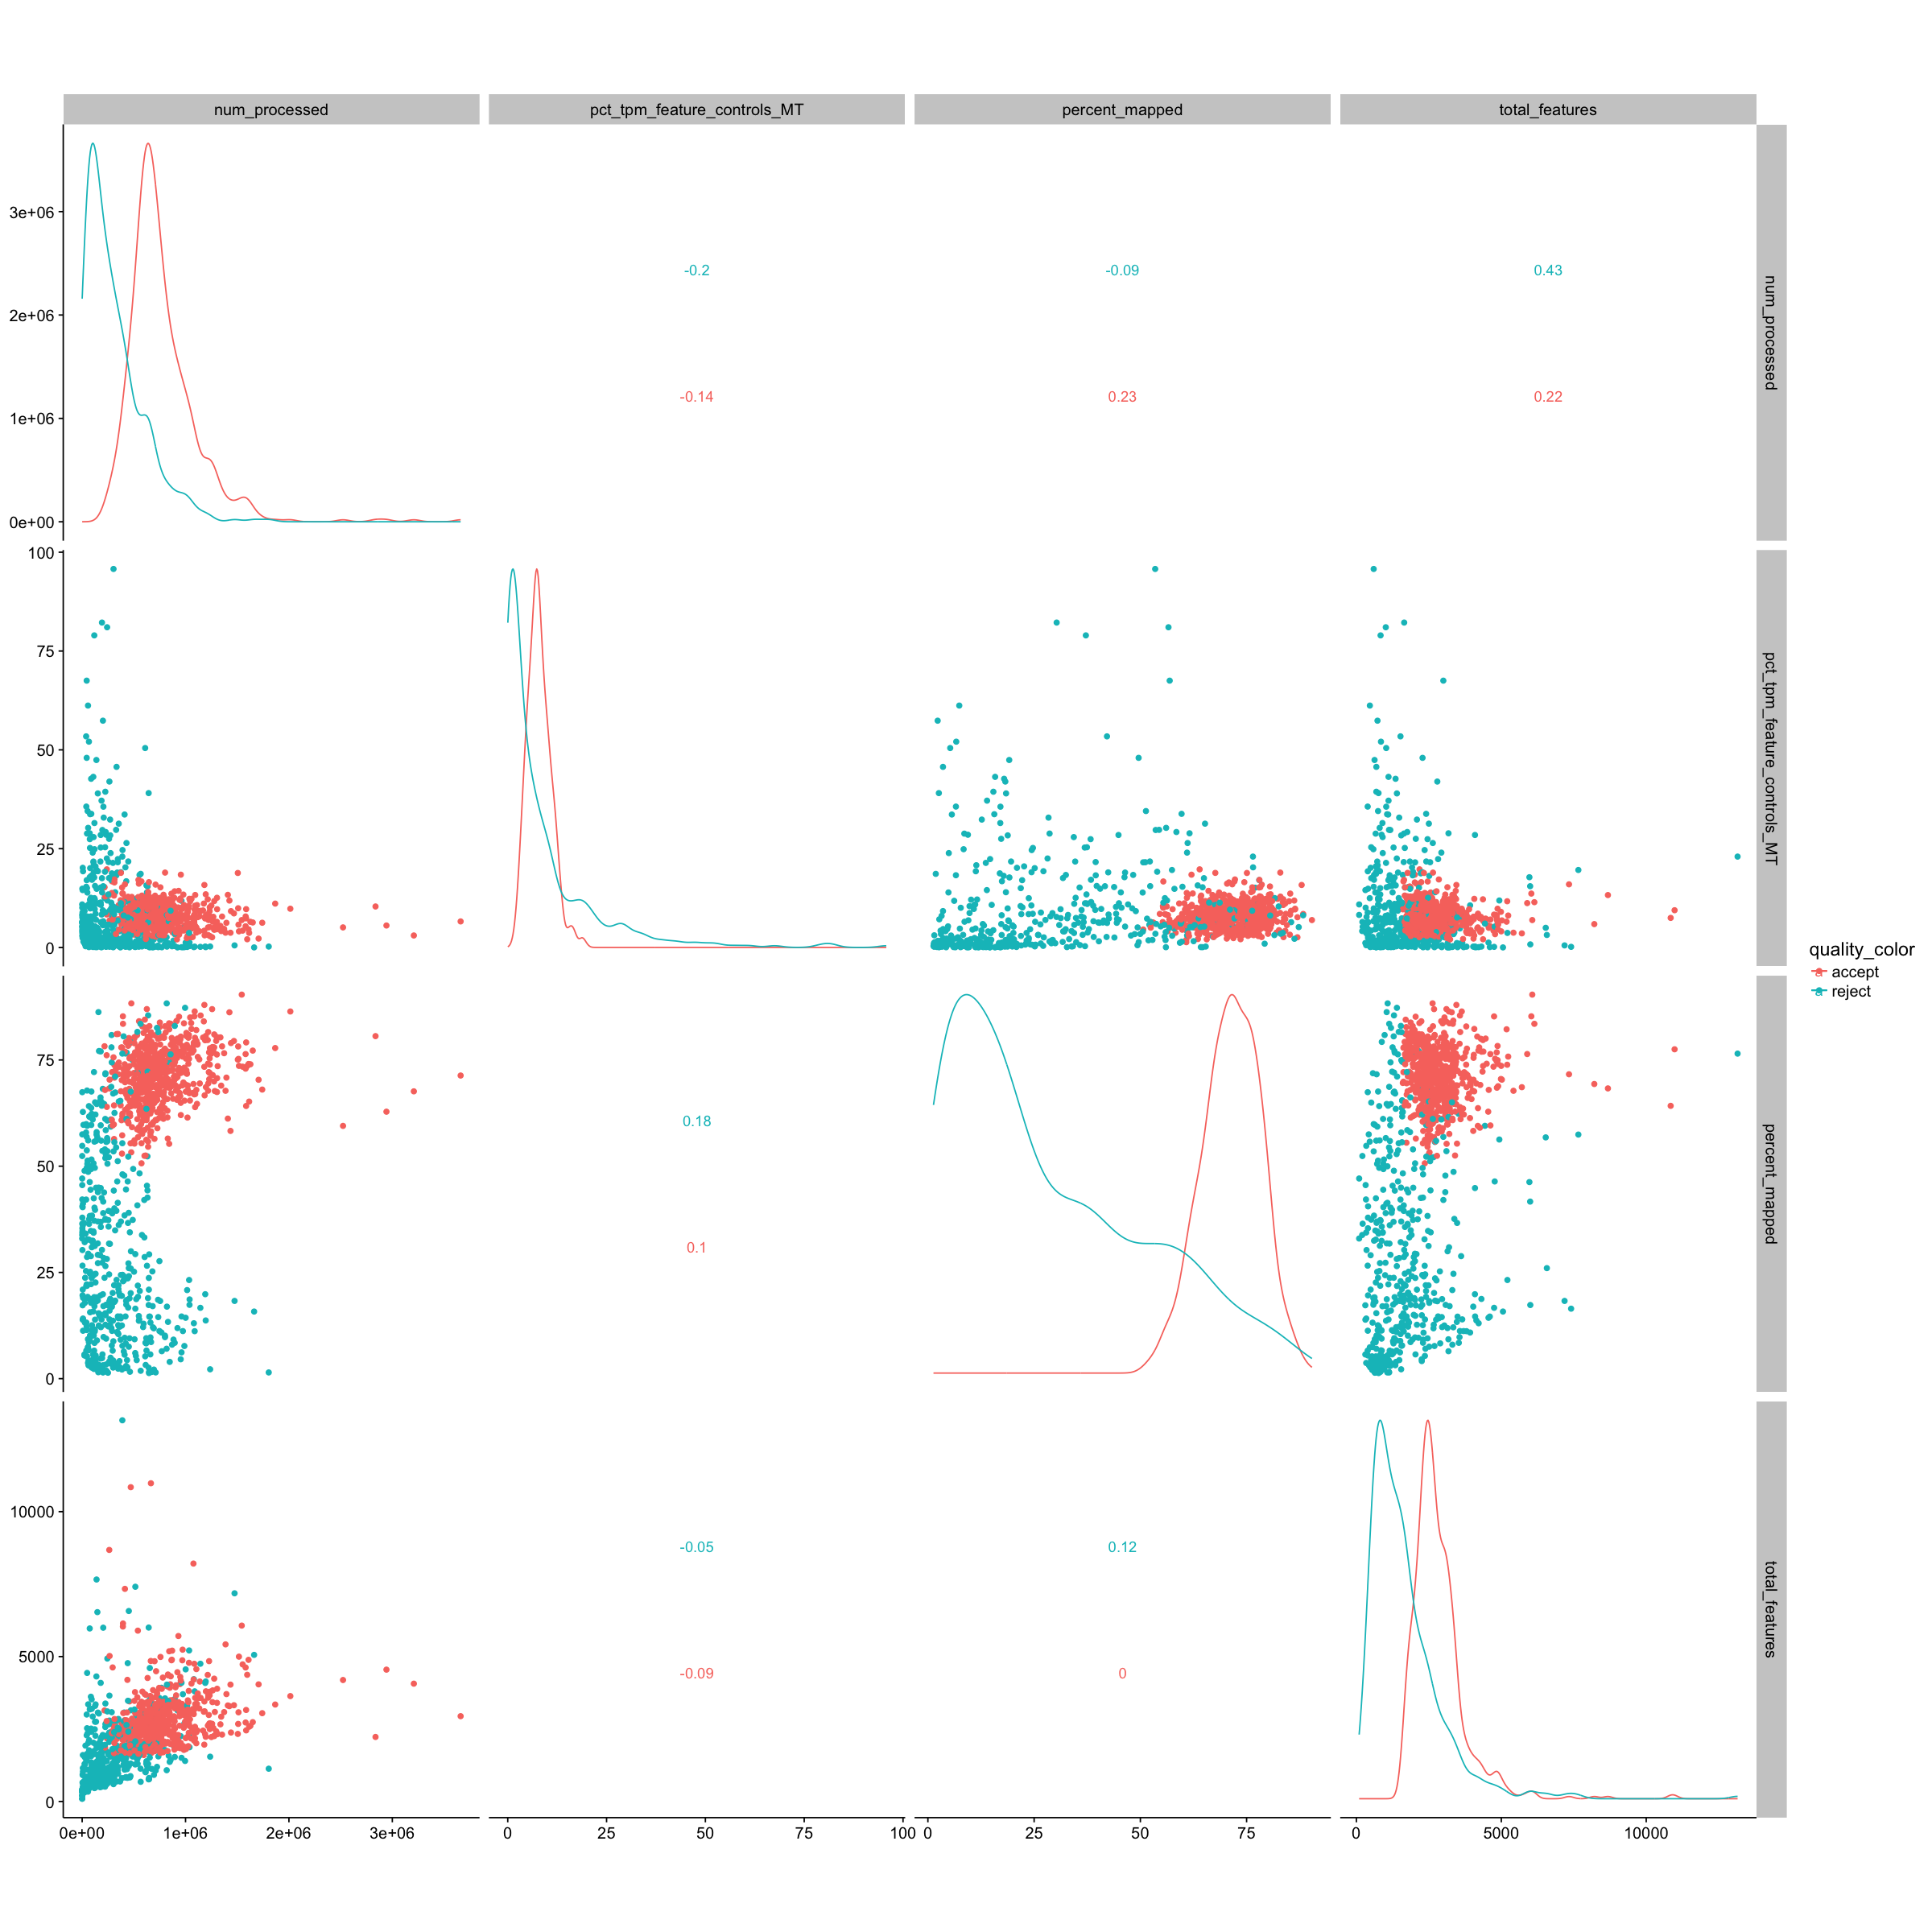

In [18]:
ggscatmat(
  sceset@phenoData@data,
  columns = c("num_processed", "total_features", 
              "percent_mapped", "pct_tpm_feature_controls_MT"),
  color = "quality_color"
)

[1] 56.6296

[1] 26686

Features  Samples 
   26686      662

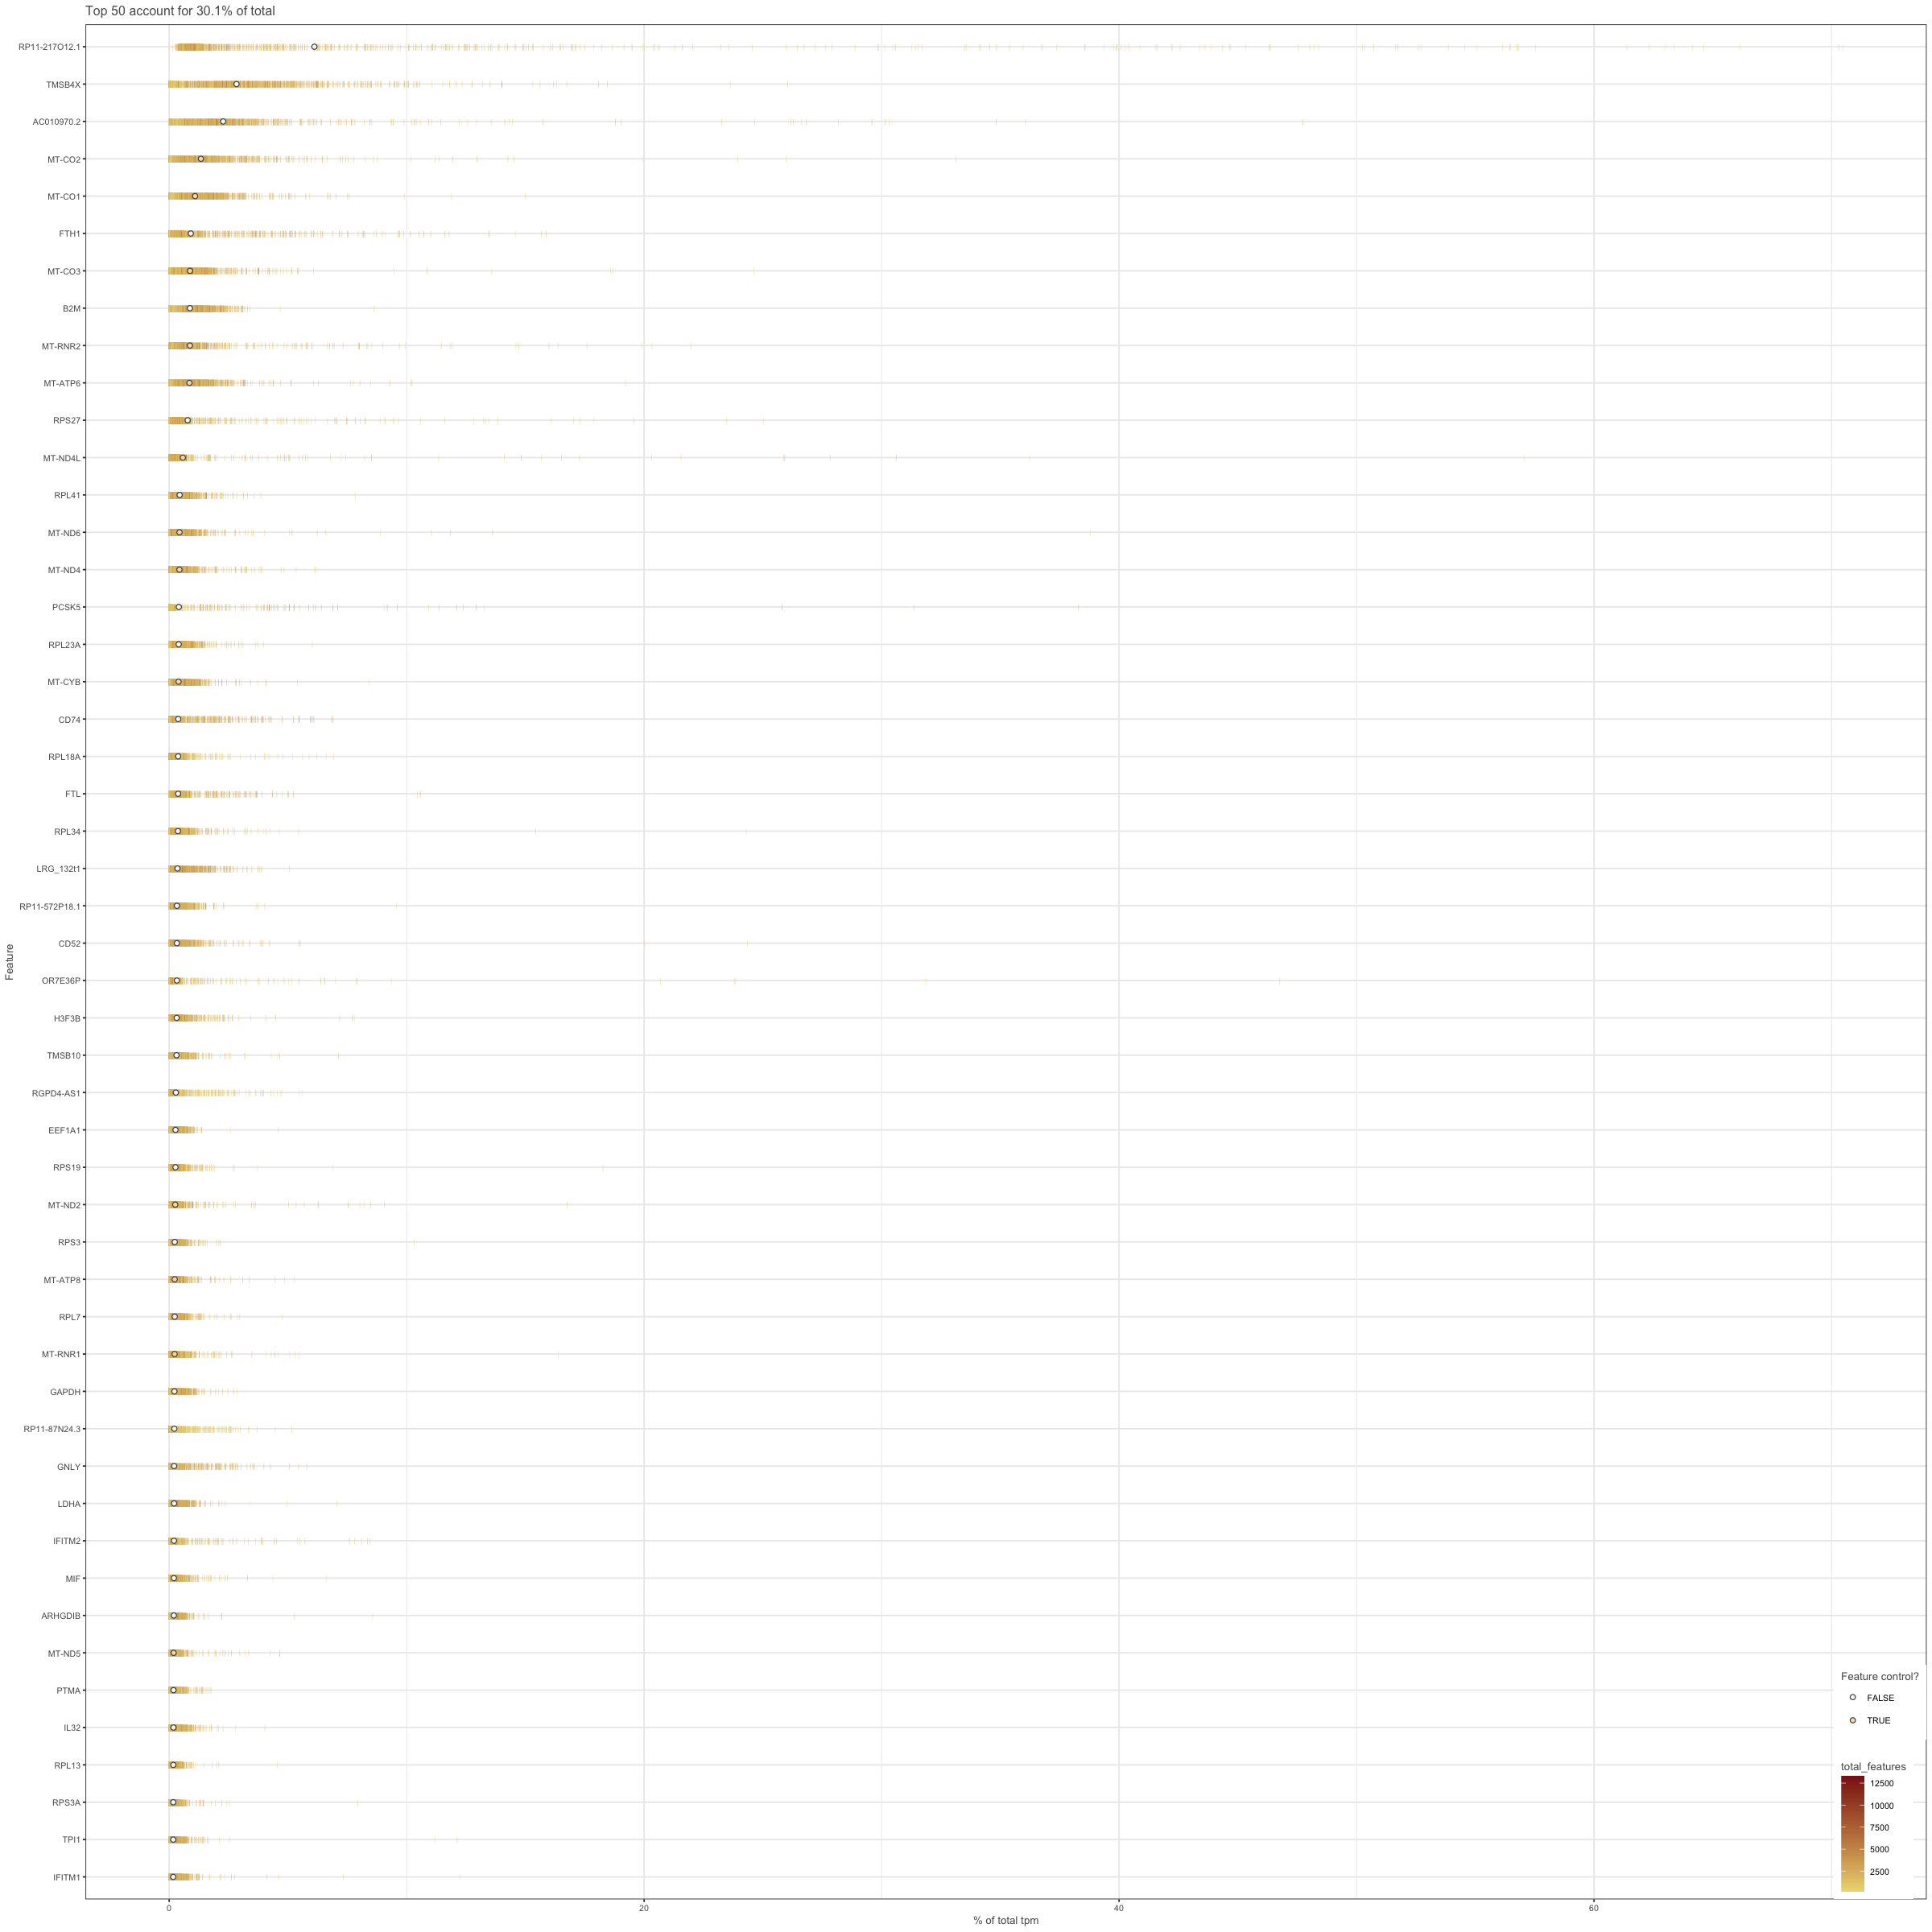

In [20]:
# Around 60%
sum(sceset$use) / length(sceset$use) * 100

# Gene Filtering
scater::plotQC(sceset, type = "highest-expression", exprs_values = "tpm")

# Remove undetectable genes
filter_genes <- apply(tpm(sceset[, pData(sceset)$use]), 1, 
                      function (x) length(x[x > 1]) > 2)
sum(filter_genes)
fData(sceset)$use <- filter_genes

dim(sceset[fData(sceset)$use, pData(sceset)$use])

# Apply the final QC filters
sc_qc <- sceset[fData(sceset)$use, pData(sceset)$use]
endog_genes <- !fData(sc_qc)$is_feature_control

In [21]:
quality_summary <- aggregate(pData(sceset)$use,
                             by = list("sample_type"=pData(sceset)[, "sample_type"]),
                             FUN=mean)
quality_summary <- merge(
  quality_summary,
  aggregate(pData(sceset)$use,
            by = list("sample_type"=pData(sceset)[, "sample_type"]),
            FUN=length),
  by = "sample_type")
colnames(quality_summary) <- c("sample_type", "pct_pass", "total")
quality_summary

sample_type,pct_pass,total
Blood CD3+,0.53005464,183
Blood DN,0.67582418,182
Blood g/d T cells,0.55494505,182
Blood SP & DP,0.78142077,183
HDM Blister CD3,0.74725275,182
HDM Blister DN,0.06010929,183
HDM Blister g/d T cells,0.68918919,74


In [32]:
# Negatively selected blister T-Cells do not pass QC

# Write out the phenoData for the quality cells
write.table(pData(sc_qc), "data/qc_cells_metadata.csv", sep = ",", quote = F)
write.table(
    pData(sc_qc)[pData(sc_qc)$sample_type == "Blood CD3+", "Row.names"],
    "data/qc_cells_files.csv", sep = ",", 
    quote = F, col.names= F, row.names = F)

In [31]:
head(pData(sc_qc))

,Row.names,file_name,donor_id,sample_name,well,plate,sample_type,tissue,cell_type,num_processed,⋯,exprs_endogenous_features,tpm_endogenous_features,log10_tpm_feature_controls_ERCC,log10_tpm_feature_controls_MT,log10_tpm_feature_controls,log10_tpm_endogenous_features,is_cell_control,use,quality_color,use_default
SCGC_00425_B03,20957_2#27,20957_2#27.cram,4375STDY6562908,SCGC_00425_B03,B03,425,Blood DN,Blood,DN,383116,⋯,10866.85,817840.4,0.0000000,4.884057,4.884057,5.912669,FALSE,TRUE,accept,TRUE
SCGC_00425_B05,20957_2#29,20957_2#29.cram,4375STDY6562910,SCGC_00425_B05,B05,425,Blood DN,Blood,DN,565043,⋯,10571.95,841374.1,2.3954487,4.627910,4.630435,5.924990,FALSE,TRUE,accept,TRUE
SCGC_00425_B07,20957_2#31,20957_2#31.cram,4375STDY6562912,SCGC_00425_B07,B07,425,Blood DN,Blood,DN,487477,⋯,12052.00,795307.7,1.1487908,4.867288,4.867365,5.900536,FALSE,TRUE,accept,TRUE
SCGC_00425_B09,20957_2#33,20957_2#33.cram,4375STDY6562914,SCGC_00425_B09,B09,425,Blood DN,Blood,DN,778083,⋯,11118.01,774640.3,3.0227706,4.950472,4.955567,5.889101,FALSE,TRUE,accept,TRUE
SCGC_00425_B11,20957_2#35,20957_2#35.cram,4375STDY6562916,SCGC_00425_B11,B11,425,Blood DN,Blood,DN,506127,⋯,11096.12,792546.0,1.1382547,4.992913,4.992969,5.899025,FALSE,TRUE,accept,TRUE
SCGC_00425_B15,20957_2#39,20957_2#39.cram,4375STDY6562920,SCGC_00425_B15,B15,425,Blood DN,Blood,DN,550087,⋯,16040.82,779709.4,0.3114635,4.537157,4.537170,5.891933,FALSE,TRUE,accept,TRUE


[1] "4375STDY6562908"       "4375STDY6562910"       "4375STDY6562912"      
  [4] "4375STDY6562914"       "4375STDY6562916"       "4375STDY6562920"      
  [7] "4375STDY6562922"       "4375STDY6562924"       "4375STDY6562926"      
 [10] "4375STDY6562928"       "4375STDY6562954"       "4375STDY6562958"      
 [13] "4375STDY6562960"       "4375STDY6562962"       "4375STDY6562964"      
 [16] "4375STDY6562966"       "4375STDY6562968"       "4375STDY6562972"      
 [19] "4375STDY6562974"       "4375STDY6562976"       "4375STDY6563006"      
 [22] "4375STDY6563008"       "4375STDY6563010"       "4375STDY6563012"      
 [25] "4375STDY6563014"       "4375STDY6563016"       "4375STDY6563018"      
 [28] "4375STDY6563020"       "4375STDY6563022"       "4375STDY6563050"      
 [31] "4375STDY6563054"       "4375STDY6563056"       "4375STDY6563062"      
 [34] "4375STDY6563064"       "4375STDY6563066"       "4375STDY6563070"      
 [37] "4375STDY6563104"       "4375STDY6563106"       "4375STDY6563108"      
 [40] "4375STDY6563110"       "4375STDY6563112"       "4375STDY6563114"      
 [43] "4375STDY6563116"       "4375STDY6563118"       "4375STDY6563146"      
 [46] "4375STDY6563148"       "4375STDY6563150"       "4375STDY6563152"      
 [49] "4375STDY6563154"       "4375STDY6563160"       "4375STDY6563164"      
 [52] "4375STDY6563166"       "4375STDY6563168"       "4375STDY6563200"      
 [55] "4375STDY6563202"       "4375STDY6563210"       "4375STDY6563212"      
 [58] "4375STDY6563214"       "4375STDY6563244"       "4375STDY6563246"      
 [61] "4375STDY6563250"       "4375STDY6563252"       "4375STDY6563256"      
 [64] "4375STDY6562900"       "4375STDY6563044"       "4375STDY6563076"      
 [67] "4375STDY6563090"       "4375STDY6563170"       "4375STDY6563172"      
 [70] "4375STDY6563268"       "4375STDY6563270"       "4375STDY6563272"      
 [73] "4375STDY6563276"       "4375STDY6563278"       "4375STDY6563280"      
 [76] "4375STDY6563282"       "4375STDY6563284"       "4375STDY6563286"      
 [79] "4375STDY6563288"       "4375STDY6563316"       "4375STDY6563318"      
 [82] "4375STDY6563320"       "4375STDY6563324"       "4375STDY6563326"      
 [85] "4375STDY6563332"       "4375STDY6563334"       "4375STDY6563362"      
 [88] "4375STDY6563364"       "4375STDY6563370"       "4375STDY6563374"      
 [91] "4375STDY6563376"       "4375STDY6563378"       "4375STDY6563380"      
 [94] "4375STDY6563382"       "4375STDY6563384"       "4375STDY6563410"      
 [97] "4375STDY6563414"       "4375STDY6563416"       "4375STDY6563418"      
[100] "4375STDY6563420"       "4375STDY6563422"       "4375STDY6563424"      
[103] "4375STDY6563426"       "4375STDY6563428"       "4375STDY6563430"      
[106] "4375STDY6563432"       "4375STDY6563458"       "4375STDY6563460"      
[109] "4375STDY6563462"       "4375STDY6563464"       "4375STDY6563470"      
[112] "4375STDY6563476"       "4375STDY6563478"       "4375STDY6563480"      
[115] "4375STDY6563506"       "4375STDY6563508"       "4375STDY6563510"      
[118] "4375STDY6563514"       "4375STDY6563516"       "4375STDY6563520"      
[121] "4375STDY6563522"       "4375STDY6563524"       "4375STDY6563526"      
[124] "4375STDY6563528"       "4375STDY6563554"       "4375STDY6563556"      
[127] "4375STDY6563566"       "4375STDY6563574"       "4375STDY6563576"      
[130] "4375STDY6563612"       "4375STDY6563614"       "4375STDY6563662"      
[133] "4375STDY6563698"       "4375STDY6563700"       "4375STDY6563702"      
[136] "4375STDY6563706"       "4375STDY6563708"       "4375STDY6563712"      
[139] "4375STDY6563714"       "4375STDY6563716"       "4375STDY6563746"      
[142] "4375STDY6563750"       "4375STDY6563752"       "4375STDY6563756"      
[145] "4375STDY6563758"       "4375STDY6563760"       "4375STDY6563762"      
[148] "4375STDY6563764"       "4375STDY6563766"       "4375STDY6563768"      
[151] "4375STDY6563796"       "4375STDY6563798"       "4375STDY6563800"      
[154] "4375STDY6563802" 